In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
sheet = pd.read_excel('data_input/PX-WTI价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet[sheet['Date'] >= '2023-01-01']
sheet.tail()

,Date,PX-WTI价差,美国RBOB汽油裂解
4145,2025-03-03,362.839,24.12
4146,2025-03-04,343.308,24.72
4147,2025-03-05,353.183,24.11
4148,2025-03-06,350.729,22.62
4149,2025-03-07,NaN,22.21


In [4]:
try:
    file_path1 = os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/美国RBOB汽油裂解_合并数据.xlsx")
    if not os.path.exists(file_path1):
        os.makedirs(file_path1)
except:
    sfile_path1 = os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/美国RBOB汽油裂解_合并数据.xlsx") 
    if not os.path.exists(file_path1):
        os.makedirs(file_path1)

sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['实际值'])
sheet1 = sheet1.dropna()
sheet1.head()

,Date,美国RBOB汽油裂解
0,2025-04-04,26.64
1,2025-04-03,26.69
2,2025-04-02,28.32
3,2025-04-01,28.29
4,2025-03-31,28.81


In [5]:
file_path2  = 'eta/PX-WTI价差拟合残差-美国RBOB汽油裂解_合并数据.xlsx'
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
# 将真实值和预测值列合并为一个列
sheet2['PX-WTI价差拟合残差-美国RBOB汽油裂解'] = sheet2['真实值'].fillna(sheet2['预测值'])
# 删除原始的真实值和预测值列
sheet2 = sheet2.drop(columns=['真实值', '预测值'])
sheet2.head()

,Date,PX-WTI价差拟合残差-美国RBOB汽油裂解
0,2025-04-17,-85.8229
1,2025-04-16,-83.9055
2,2025-04-15,-83.9055
3,2025-04-14,-83.9055
4,2025-04-11,-83.9055


In [6]:
# 确保Date列是日期类型
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')

# 合并数据，保留所有行，日期重合时优先使用sheet的数据
merged_df = pd.merge(sheet, sheet1[['Date', '美国RBOB汽油裂解']], 
                    on='Date', how='outer', suffixes=('', '_sheet1'))

# 处理合并后的列：sheet中有数据则保留，否则使用sheet1的数据
mask = merged_df['美国RBOB汽油裂解'].isna()
merged_df.loc[mask, '美国RBOB汽油裂解'] = merged_df.loc[mask, '美国RBOB汽油裂解_sheet1']
sheet3 = merged_df.drop(columns=['美国RBOB汽油裂解_sheet1']).sort_values('Date', ascending=True)
sheet3['美国RBOB汽油裂解'] = sheet3['美国RBOB汽油裂解'].interpolate(method='linear')
last_day = sheet3['Date'][sheet3['PX-WTI价差'].last_valid_index()]
sheet3 = sheet3[~((sheet3['Date'] < last_day) & (sheet3['PX-WTI价差'].isna()))]
sheet3.head()

,Date,PX-WTI价差,美国RBOB汽油裂解
0,2023-01-03,402.367,22.21
1,2023-01-04,405.824,21.91
2,2023-01-05,407.641,21.49
3,2023-01-06,421.101,20.46
4,2023-01-09,414.779,21.59


In [7]:
merged_df_2 = pd.merge(sheet3, sheet2[['Date', 'PX-WTI价差拟合残差-美国RBOB汽油裂解']], 
                    on='Date', how='left')
sheet_daily = merged_df_2.copy()
sheet_daily['PX-WTI价差拟合残差-美国RBOB汽油裂解'] = sheet_daily['PX-WTI价差拟合残差-美国RBOB汽油裂解'].interpolate(method='linear')
sheet_daily.tail()

,Date,PX-WTI价差,美国RBOB汽油裂解,PX-WTI价差拟合残差-美国RBOB汽油裂解
559,2025-03-31,NaN,28.81,-82.3667
560,2025-04-01,NaN,28.29,-82.3667
561,2025-04-02,NaN,28.32,-82.3667
562,2025-04-03,NaN,26.69,-82.3667
563,2025-04-04,NaN,26.64,-82.3667


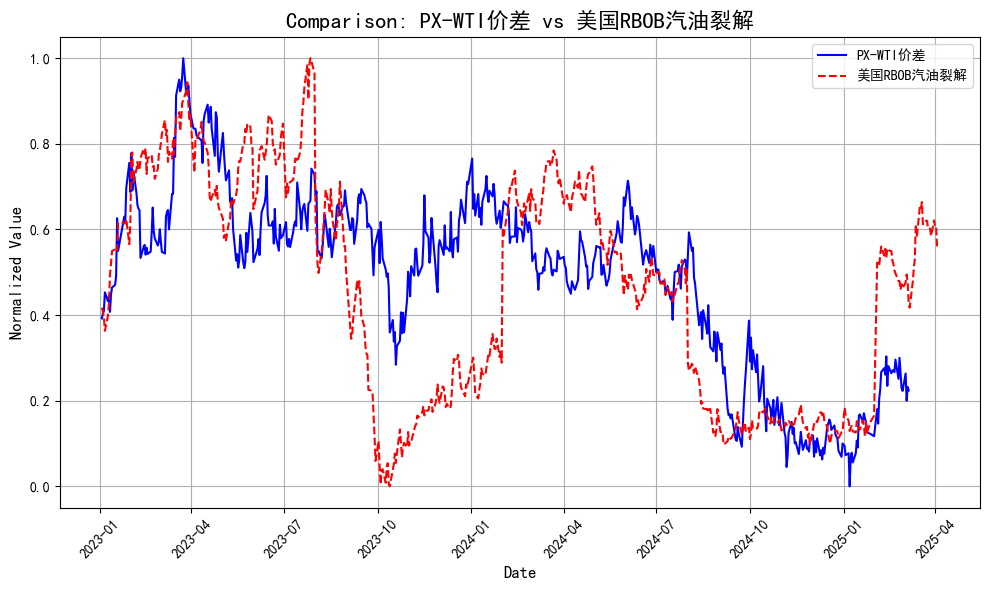

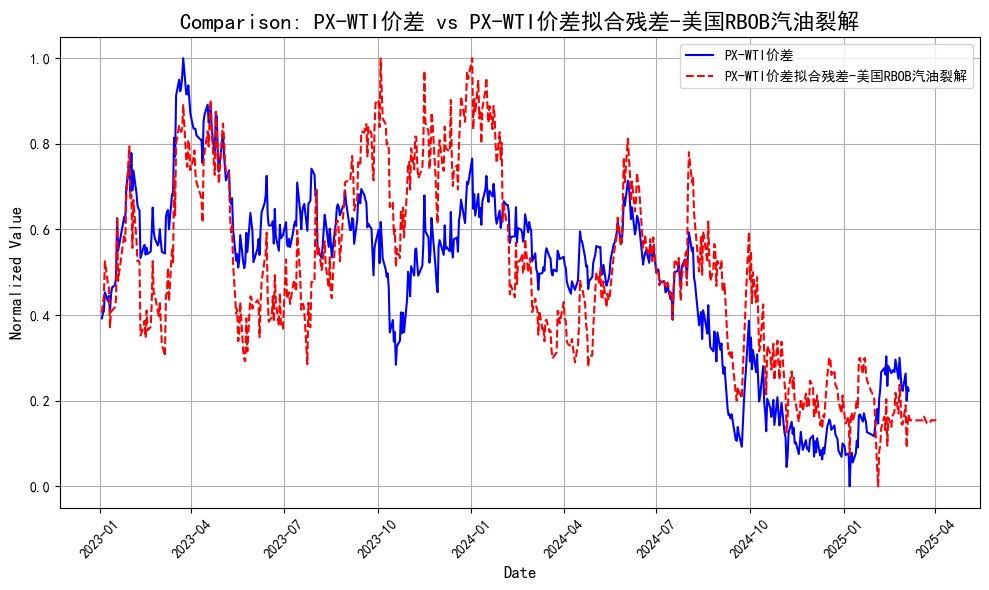

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='PX-WTI价差', 
    compare_cols=['美国RBOB汽油裂解','PX-WTI价差拟合残差-美国RBOB汽油裂解']
)

---

In [9]:
# 添加新列 PX-WTI价差_预测
sheet_daily['PX-WTI价差_预测'] = 4.8910* sheet_daily['美国RBOB汽油裂解'] + 319.2874 + sheet_daily['PX-WTI价差拟合残差-美国RBOB汽油裂解']
sheet_daily.tail()

,Date,PX-WTI价差,美国RBOB汽油裂解,PX-WTI价差拟合残差-美国RBOB汽油裂解,PX-WTI价差_预测
559,2025-03-31,NaN,28.81,-82.3667,377.83041
560,2025-04-01,NaN,28.29,-82.3667,375.28709
561,2025-04-02,NaN,28.32,-82.3667,375.43382
562,2025-04-03,NaN,26.69,-82.3667,367.46149
563,2025-04-04,NaN,26.64,-82.3667,367.21694


In [10]:
last_day = sheet_daily['Date'][sheet_daily['PX-WTI价差'].last_valid_index()]


# 创建每日数据框
merged_df_daily = pd.DataFrame()
merged_df_daily['Date'] = sheet_daily['Date']
merged_df_daily['真实值'] = sheet_daily['PX-WTI价差']
merged_df_daily['预测值'] = None

# 在last_day之后填充预测值
mask = merged_df_daily['Date'] > last_day
merged_df_daily.loc[mask, '预测值'] = sheet_daily.loc[mask, 'PX-WTI价差_预测']

# 创建月度数据框 
merged_df_montly = pd.DataFrame()
merged_df_montly['Date'] = sheet_daily['Date']
merged_df_montly['真实值'] = sheet_daily['PX-WTI价差']
merged_df_montly['预测值'] = None

# 在2024-01-01之后填充预测值
mask = merged_df_montly['Date'] > '2024-01-01'
merged_df_montly.loc[mask, '预测值'] = sheet_daily.loc[mask, 'PX-WTI价差_预测']


In [11]:
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/PX-WTI价差_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily

,Date,真实值,预测值
563,2025/04/04,NaN,367.21694
562,2025/04/03,NaN,367.46149
561,2025/04/02,NaN,375.43382
560,2025/04/01,NaN,375.28709
559,2025/03/31,NaN,377.83041
...,...,...,...
4,2023/01/09,414.779,None
3,2023/01/06,421.101,None
2,2023/01/05,407.641,None
1,2023/01/04,405.824,None


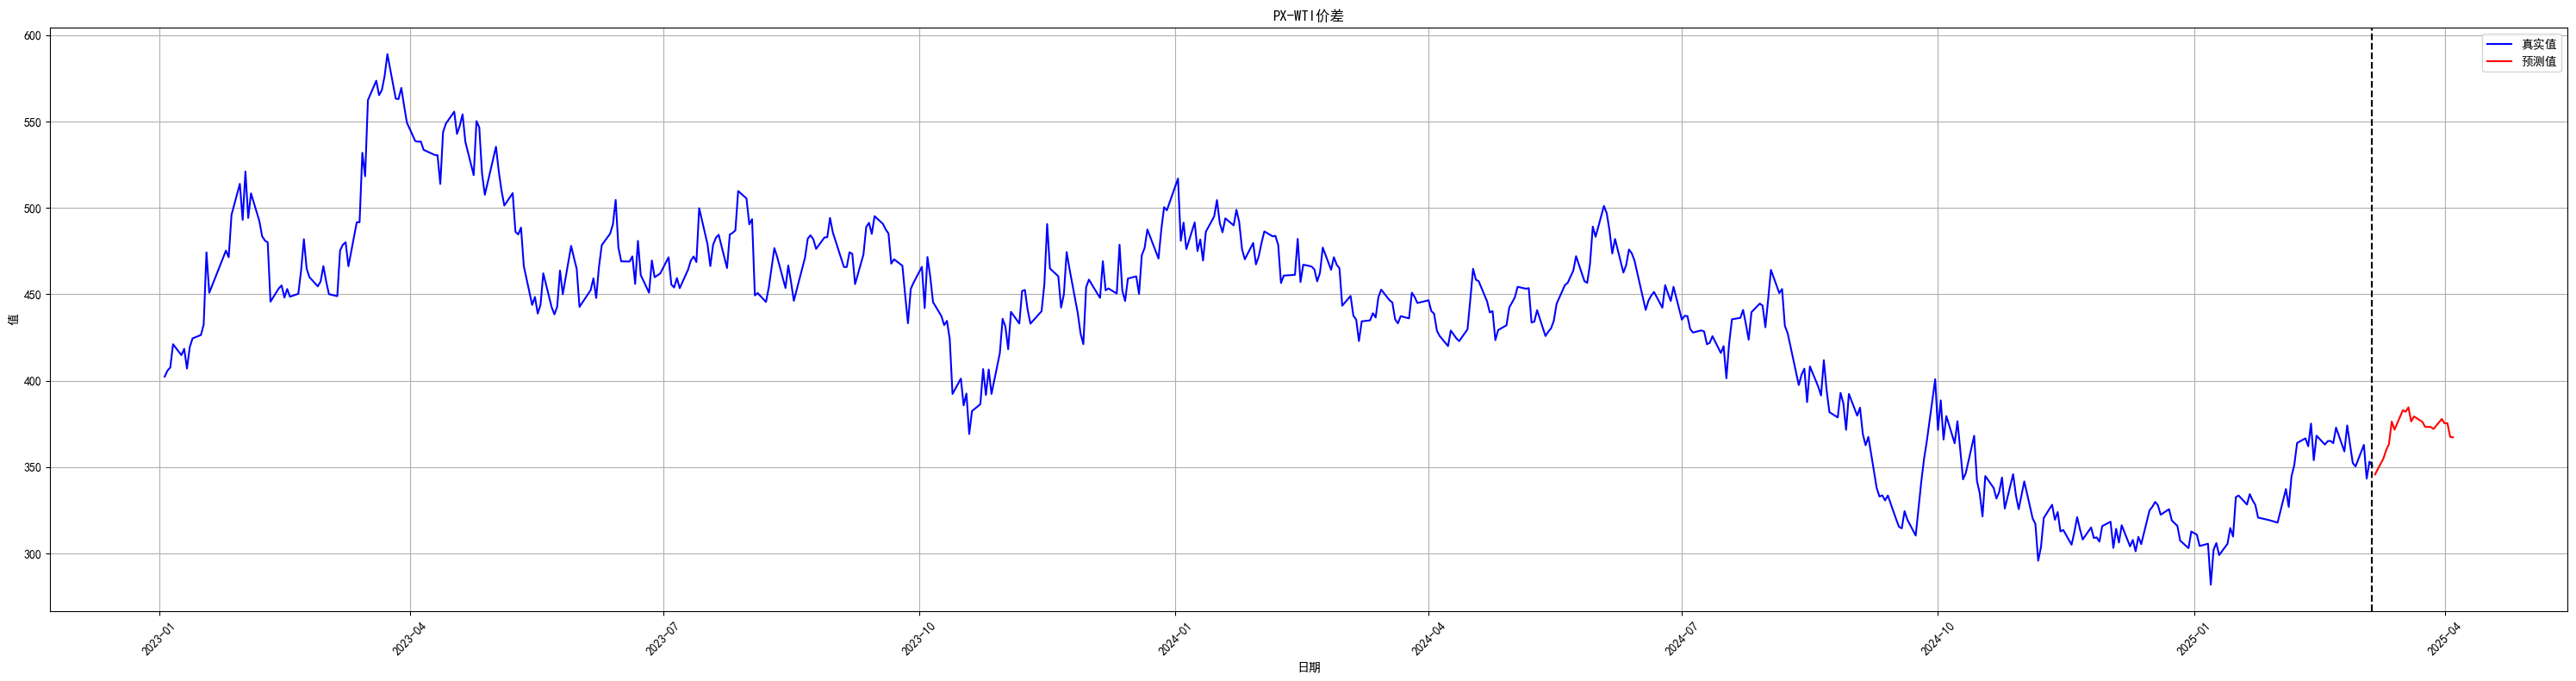

In [12]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily
# 将日期格式转换回datetime格式用于绘图
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')

# 绘制预测值曲线(红色) 
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['预测值'], color='red', label='预测值')

# 计算并绘制中间垂直线(黑色)
avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('PX-WTI价差')
plt.xlabel('日期')
plt.ylabel('值')

# 旋转x轴日期标签以防重叠
plt.xticks(rotation=45)
# 自动调整布局
plt.grid(True)
plt.tight_layout()
# 显示图形
plt.show()




In [13]:
merged_df_montly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_montly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/PX-WTI价差_月度数据.xlsx', index=False,float_format= '%.0f')
merged_df_monthly.head()

,Date,真实值,预测值
27,2025/04/30,NaN,371.349835
26,2025/03/31,352.514750,368.229494
25,2025/02/28,358.951000,358.949887
24,2025/01/31,315.028053,315.027423
23,2024/12/31,314.408810,314.408197


In [14]:
merged_df_daily

,Date,真实值,预测值
563,2025-04-04,NaN,367.21694
562,2025-04-03,NaN,367.46149
561,2025-04-02,NaN,375.43382
560,2025-04-01,NaN,375.28709
559,2025-03-31,NaN,377.83041
...,...,...,...
4,2023-01-09,414.779,None
3,2023-01-06,421.101,None
2,2023-01-05,407.641,None
1,2023-01-04,405.824,None
